### Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import random
import heapq
import os 
import time 

### Classes

In [17]:
class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = str(id)
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }
        # this means that there are 3 M1 machines
        # the [] nested inside the list refers to the usage timings of the i-th M1 machine
        # for example: [ [(0,3), (4,5)], [], []]
        # means that the 1st machine is used from (0,3) and (4,5)

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None, predecessors=None):
        self.id = str(id)
        self.successor = str(successors) if successors else None
        self.predecessors = predecessors if predecessors else []
        self.workcenter = str(workcenter)
        self.machine = str(machine)
        self.scheduled_machin_idx = None
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = due_date
        self.scheduled = False

    # Comparison methods
    def __lt__(self, other):
        return (self.due_date if self.due_date is not None else float('inf')) < (other.due_date if other.due_date is not None else float('inf'))

    def __le__(self, other):
        return (self.due_date if self.due_date is not None else float('inf')) <= (other.due_date if other.due_date is not None else float('inf'))

    def __eq__(self, other):
        return (self.due_date if self.due_date is not None else float('inf')) == (other.due_date if other.due_date is not None else float('inf'))

    def __ne__(self, other):
        return not self.__eq__(other)

    def __gt__(self, other):
        return not self.__le__(other)

    def __ge__(self, other):
        return not self.__lt__(other)

### Loading Functions

In [18]:
def load_operations(df, filename=None):

    operations = {}

    for index, row in df.iterrows():
        op = Operation(
            id=str(row['operation']),
            processing_time=row['processing_time'],
            workcenter=row['workcenter'],
            machine=row['machine'],
            due_date=row['due_date'],
            predecessors=row['predecessor_operations']
        )
        operations[op.id] = op

    for index, row in df.iterrows():
        current_op_id = row['operation']
        predecessor_ops = row['predecessor_operations']
        for predecessor in predecessor_ops:
            operations[predecessor].successor = current_op_id
    
    return operations

def load_factory(df_machine):
    factory = {}
    for idx, row in df_machine.iterrows():
        workcenter = row['workcenter']
        dict_machines = {}
        for machine in (df_machine.columns[1:]): 
            dict_machines[machine] = [[] for _ in range(row[machine])]
        factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)
    return factory

def calculate_makespan(factory):
    list_schedules = []
    for workcenter_key in factory:
        for _, machine_schedule in factory[workcenter_key].machines.items():
            flattened_schedule = [item for sublist in machine_schedule for item in sublist]
            list_schedules += flattened_schedule

    _max = max(list_schedules, key=lambda x: x[1])[1]
    _min = min(list_schedules, key=lambda x: x[0])[0]

    return _max - _min

def format_schedule(scheduled_operations, factory):
    df_schedule = pd.DataFrame()
    for i, operation in enumerate(scheduled_operations): 
        df_schedule.at[i, "WorkCenter"] = operation.workcenter
        df_schedule.at[i, "Machine"] = operation.machine
        df_schedule.at[i, "MachineIdx"] = operation.scheduled_machine_idx+1
        df_schedule.at[i, "Operation"] = operation.id
        df_schedule.at[i, "Start"] = operation.start_time
        df_schedule.at[i, "End"] = operation.start_time + operation.processing_time
    df_schedule['PercentCompletion'] = 100  

    for workcenter_key in factory: 
        workcenter = factory[workcenter_key]
        for machine_type, machine_schedules in workcenter.machines.items():
            for machine_idx, machine_schedule in enumerate(machine_schedules): 
                if len(machine_schedule) == 0:
                    new_row = {
                        "WorkCenter": workcenter.id,
                        "Machine": machine_type,
                        "MachineIdx": machine_idx,
                        "Operation": None,
                        "Start": None,
                        "End": None,
                        "PercentCompletion": None
                    }
                    new_row_df = pd.DataFrame([new_row])
                    df_schedule = pd.concat([df_schedule, new_row_df], ignore_index=True)

    return df_schedule

### Solving Makespan and Workcenter Subproblem

In [31]:
def solve_spm(V_Y, makespan_values):
    SPM_value = 0
    for V, Z in zip(V_Y, makespan_values):
        if V > 1:
            SPM_value += V * Z
        elif V == 1:
            SPM_value += Z
        else:
            SPM_value += 0
    return SPM_value

def solve_spw(operations, workcenter, V_Y, U_ij):
    operations.sort(key=lambda op: (op.processing_time / (op.due_date if op.due_date else float('inf')), -op.processing_time))
    
    # Initialize completion times for each machine in the workcenter
    C = {machine: 0 for machine in workcenter.machines}
    
    Q = []
    for op in operations:
        print(f"op: {op}")
        print(f"operation due date: {op.due_date}")
        heapq.heappush(Q, (op.due_date, op))
    
    L_Y = 0
    makespan = 0
    
    while Q:
        _, op = heapq.heappop(Q)
        available_machine = min(C, key=C.get)
        op.start_time = C[available_machine]
        op.end_time = op.start_time + op.processing_time
        C[available_machine] = op.end_time
        makespan = max(makespan, op.end_time)
        L_Y += V_Y * makespan
        if op.successor:
            succ = next((o for o in operations if o.id == op.successor), None)
            if succ and succ.end_time is not None and op.end_time is not None:
                L_Y += U_ij.get((op.id, succ.id), 0) * succ.end_time - U_ij.get((op.id, succ.id), 0) * op.end_time
    
    return L_Y, operations


### Subgradient Search Procedure

In [20]:
def subgradient_search(workcenters, operations, max_iterations=100, s=0.1):
    lambda_ij = {}  # Initial dual costs from linear relaxation
    delta_Y = {wc.id: 1 for wc in workcenters.values()}  # Initialize delta_Y with correct keys from workcenters
    
    U_ij = {k: v for k, v in lambda_ij.items()}
    V_Y = {Y: delta_Y[Y] for Y in delta_Y}
    
    for k in range(1, max_iterations + 1):
        if sum(V_Y.values()) > 1:
            total = sum(V_Y.values())
            for Y in V_Y:
                V_Y[Y] = V_Y[Y] / total

        L_Y_total = 0
        makespan_values = []
        for wc in workcenters.values():
            L_Y, scheduled_operations = solve_spw([op for op in operations.values() if op.workcenter == wc.id], wc, V_Y[wc.id], U_ij)
            L_Y_total += L_Y
            makespan_values.append(max(op.end_time for op in scheduled_operations if op.end_time is not None))

        pseudo_lower_bound = L_Y_total
        
        norm_F_S = sum((next(op.end_time for op in operations.values() if op.id == j) - next(op.start_time for op in operations.values() if op.id == i))**2 for i, j in lambda_ij.keys())
        norm_Z_ZY = sum((max(makespan_values) - ZY)**2 for ZY in makespan_values)
        
        for (i, j) in U_ij.keys():
            S_i = next(op.start_time for op in operations.values() if op.id == i)
            F_j = next(op.end_time for op in operations.values() if op.id == j)
            U_ij[(i, j)] += s * k * (F_j - S_i) / (norm_F_S + norm_Z_ZY)**0.5
            if U_ij[(i, j)] <= 0:
                U_ij[(i, j)] = 0
        
        for Y in V_Y.keys():
            Z = max(makespan_values)
            ZY = makespan_values[list(V_Y.keys()).index(Y)]
            V_Y[Y] += s * k * (Z - ZY) / (norm_F_S + norm_Z_ZY)**0.5
        
        if k >= 100:
            break

    return U_ij, V_Y


### Constructing Lower Bounds

In [21]:
def calculate_lower_bounds(workcenters, operations):
    lower_bounds = {}
    for wc in workcenters.values():
        op_list = [op for op in operations.values() if op.workcenter == wc.id]
        if not op_list:
            continue
        
        f_Y = len(wc.machines[list(wc.machines.keys())[0]])  # Number of machines in the work center
        
        # Calculate LB0_Y
        LB0_Y = max((op.due_date if op.due_date is not None else 0) + op.processing_time for op in op_list)
        
        # Calculate LB1_Y
        min_due_date = min((op.due_date if op.due_date is not None else 0) for op in op_list)
        total_processing_time = sum(op.processing_time for op in op_list)
        LB1_Y = min_due_date + (1 / f_Y) * total_processing_time
        
        # Calculate LB2_Y
        sorted_due_dates = sorted((op.due_date if op.due_date is not None else 0) for op in op_list)
        sum_r = sum(sorted_due_dates[:f_Y]) if len(sorted_due_dates) >= f_Y else sum(sorted_due_dates)
        LB2_Y = (1 / f_Y) * (sum_r + total_processing_time)
        
        lower_bounds[wc.id] = max(LB0_Y, LB1_Y, LB2_Y)
    
    overall_lower_bound = min(lower_bounds.values()) if lower_bounds else float('inf')
    return overall_lower_bound


### Constructing Upper Bounds

In [22]:
# def generate_upper_bound(operations, workcenters):
#     # Step 1: Sort operations by ascending order of finishing times
#     L = sorted(operations.values(), key=lambda op: op.end_time if op.end_time is not None else float('inf'))
#     L_index = {op.id: i for i, op in enumerate(L)}
    
#     # Initialize T, C, and other necessary structures
#     T = {wc.id: np.zeros(len(wc.machines)) for wc in workcenters.values()}
#     C = {op.id: 0 for op in operations.values()}
    
#     # Convert list to a set for efficient membership testing
#     operations_set = set(op.id for op in L)
    
#     # Step 2: Initialize Q, B_j, and other necessary structures
#     Q = set(op.id for op in L)
    
#     while Q:
#         # Step 3: Setup Q' with operations that have all predecessors assigned
#         Q_prime = set(j for j in Q if all(pred in C and C[pred] <= operations[pred].end_time for pred in operations[j].predecessors))
        
#         if not Q_prime:
#             raise ValueError("No operations with all predecessors assigned. Check input data.")
        
#         # Step 4: Setup P with probability of selecting each operation
#         P = {}
#         q = len(Q_prime)
#         for j in Q_prime:
#             i = L_index[j]
#             P[j] = max(2 * (q - i) / (q * (q + 1)), 0)
        
#         # Ensure all probabilities are positive
#         min_prob = min(P.values())
#         if min_prob <= 0:
#             offset = abs(min_prob) + 1e-3
#             P = {k: v + offset for k, v in P.items()}
        
#         # Normalize probabilities to ensure they sum to 1
#         total_weight = sum(P.values())
#         P = {k: v / total_weight for k, v in P.items()}
        
#         print(f"Q_prime: {Q_prime}")
#         print(f"P: {P}")
        
#         # Select an operation j* from Q' based on probabilities P
#         op_j_star_id = random.choices(list(P.keys()), weights=list(P.values()), k=1)[0]
#         op_j_star = operations[op_j_star_id]
        
#         print(f"Selected operation: {op_j_star_id}")
        
#         # Step 5: Find a machine y* in workcenter h_y* to process j*
#         best_wc, best_machine, best_time = None, None, float('inf')
#         for wc in workcenters.values():
#             for y in range(len(wc.machines)):
#                 T_y = max(T[wc.id][y], max(C[pred] for pred in op_j_star.predecessors) if op_j_star.predecessors else 0)
#                 if T_y < best_time:
#                     best_wc, best_machine, best_time = wc, y, T_y
        
#         print(f"Assigned to workcenter: {best_wc.id}, machine: {best_machine}, start time: {best_time}")
        
#         # Step 6: Assign operation j* to machine y* and update makespan
#         start_time = best_time
#         end_time = start_time + op_j_star.processing_time
#         T[best_wc.id][best_machine] = end_time
#         C[op_j_star.id] = end_time
#         op_j_star.start_time = start_time
#         op_j_star.end_time = end_time
#         Q.remove(op_j_star.id)
        
#         print(f"Operation {op_j_star_id} scheduled from {start_time} to {end_time}")
    
#     # Return the completion times as the upper bound
#     makespan = max(C.values())
#     return makespan
def generate_upper_bound(operations, workcenters, lower_bound):
    # Initialize machine availability
    machine_availability = {wc.id: {m: 0 for m in wc.machines.keys()} for wc in workcenters.values()}
    
    # Initialize operation start and end times
    for op in operations.values():
        op.start_time = None
        op.end_time = None

    # Function to check if all predecessors of an operation are completed
    def predecessors_completed(op):
        return all(operations[predecessor].end_time is not None for predecessor in op.predecessors)

    # List of operations to be scheduled
    unscheduled_ops = list(operations.values())

    while unscheduled_ops:
        for op in unscheduled_ops:
            if predecessors_completed(op):
                # Find the earliest time the operation can start
                earliest_start_time = max([operations[predecessor].end_time for predecessor in op.predecessors], default=0)
                workcenter = workcenters[op.workcenter]
                machine_id = None
                start_time = None

                # Find the earliest available machine
                for m in workcenter.machines:
                    available_time = machine_availability[op.workcenter][m]
                    if available_time <= earliest_start_time:
                        machine_id = m
                        start_time = earliest_start_time
                        break
                    if start_time is None or available_time < start_time:
                        machine_id = m
                        start_time = available_time

                op.start_time = start_time
                op.end_time = op.start_time + op.processing_time
                machine_availability[op.workcenter][machine_id] = op.end_time

        # Remove scheduled operations from the list
        unscheduled_ops = [op for op in unscheduled_ops if op.end_time is None]

    # Calculate the makespan
    makespan = max(op.end_time for op in operations.values())
    upper_bound = max(lower_bound, makespan)
    return upper_bound

### Plot Gantt Chart Function

In [23]:
def schedule_operations(operations, workcenters):
    # Initialize completion times for each machine in all workcenters
    machine_completion_times = {wc.id: {machine: [0] * len(wc.machines[machine]) for machine in wc.machines} for wc in workcenters.values()}
    
    # Sort operations by their processing time / due date ratio
    operations_sorted = sorted(operations.values(), key=lambda op: (op.processing_time / (op.due_date if op.due_date else float('inf')), -op.processing_time))
    
    for op in operations_sorted:
        # Determine the earliest start time based on predecessor completion times
        if op.predecessors:
            predecessor_end_times = [operations[pred_id].end_time for pred_id in op.predecessors]
            earliest_start_time = max(predecessor_end_times)
        else:
            earliest_start_time = 0
        
        # Determine the machine's next available time
        machine_times = machine_completion_times[op.workcenter][op.machine]
        machine_next_available_time = min(machine_times)
        machine_index = machine_times.index(machine_next_available_time)
        
        # Schedule the operation to start after the latest of the predecessor end times or machine availability
        op.start_time = max(earliest_start_time, machine_next_available_time)
        op.end_time = op.start_time + op.processing_time
        
        # Update the machine's completion time
        machine_completion_times[op.workcenter][op.machine][machine_index] = op.end_time

def plot_gantt_chart_by_workcenter(operations):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sort operations by start time for plotting
    operations_sorted = sorted(operations.values(), key=lambda op: op.start_time)
    
    # Assign colors to different workcenters
    workcenters = list(set(op.workcenter for op in operations.values()))
    colors = plt.cm.get_cmap('tab20', len(workcenters))
    color_map = {wc: colors(i) for i, wc in enumerate(workcenters)}
    
    # Aggregate operations by workcenter
    workcenter_ops = {wc: [] for wc in workcenters}
    for op in operations_sorted:
        workcenter_ops[op.workcenter].append(op)
    
    y_labels = []
    y_ticks = []
    for i, wc in enumerate(workcenters):
        y_ticks.append(i)
        y_labels.append(wc)
        for op in workcenter_ops[wc]:
            start = op.start_time
            end = op.end_time
            if start is not None and end is not None:
                ax.barh(i, end - start, left=start, color=color_map[wc], edgecolor='black')
                ax.text(start + (end - start) / 2, i, f"{op.id}", va='center', ha='center', color='black', fontsize=8)
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Workcenter')
    ax.set_title('Gantt Chart for Assembly Scheduling')
    
    plt.tight_layout()
    plt.show()

# Basic Test Cases

### Test Case #1

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,"[D.10, F.20]",0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,"[A.10, C.10]",1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


op: <__main__.Operation object at 0x0000019B56B36E50>
operation due date: 0
op: <__main__.Operation object at 0x0000019B543E86D0>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56AEF290>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56ACD0D0>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56AEFFD0>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56AEEB50>
operation due date: 14
op: <__main__.Operation object at 0x0000019B56B36E50>
operation due date: 0
op: <__main__.Operation object at 0x0000019B543E86D0>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56AEF290>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56ACD0D0>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56AEFFD0>
operation due date: 0
op: <__main__.Operation object at 0x0000019B56AEEB50>
operation due date: 14
op: <__main__.Operation object at 0x0000019B56B36E50>
operation due date: 0
op: <__mai

C:\Users\natha\AppData\Local\Temp\ipykernel_392\1697876345.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(workcenters))


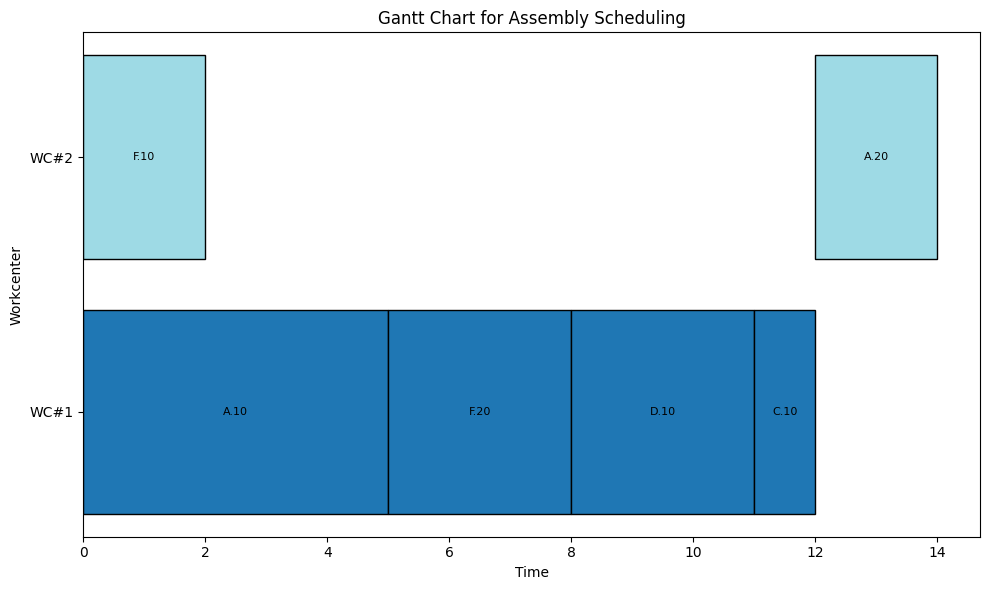

In [32]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10', 'F.20'], [], ['A.10', 'C.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_BOM)
display(df_machine)

operations = load_operations(df_BOM)
factory = load_factory(df_machine)

# Assume some initial values for dual costs for demonstration
# lambda_ij = {('A', 'C'): 1, ('B', 'D'): 1, ('C', 'E'): 1, ('D', 'E'): 1, ('E', 'F'): 1, ('G', 'F'): 1, ('H', 'G'): 1, ('P', 'R'): 1, ('Q', 'R'): 1, ('R', 'S'): 1, ('U', 'S'): 1}
# delta_Y = {wc.id: 1 for wc in workcenters.values()}

U_ij, V_Y = subgradient_search(factory, operations, max_iterations=100, s=0.1)
for wc in factory.values():
    solve_spw([op for op in operations.values() if op.workcenter == wc.id], wc, V_Y[wc.id], U_ij)

# print("U_ij:", U_ij)
# print("V_Y:", V_Y)

lower_bound = calculate_lower_bounds(factory, operations)
print("Overall Lower Bound:", lower_bound)

# Generate upper bound
upper_bound = generate_upper_bound(operations, factory, lower_bound)
print("Upper Bound:", upper_bound)

# Proceed with the rest of the process
schedule_operations(operations, factory)
plot_gantt_chart_by_workcenter(operations)

### Test Case #2

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,[],0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,[],1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,2
1,WC#2,1


Overall Lower Bound: 6.0
Upper Bound: 12


C:\Users\natha\AppData\Local\Temp\ipykernel_392\1697876345.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(workcenters))


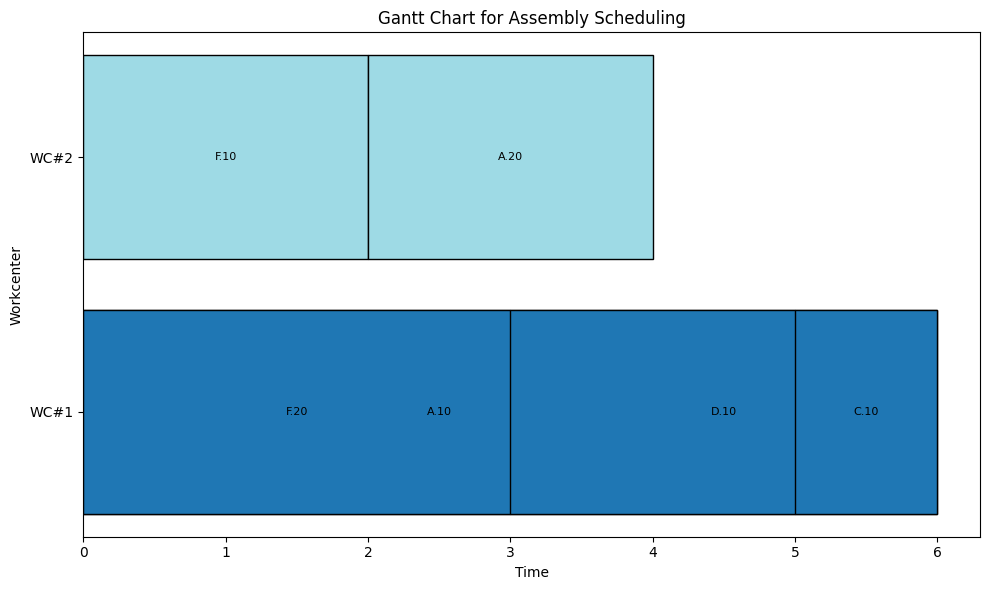

In [25]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], [], [], [], [], []],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})

df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [2, 1]
})
display(df_BOM)
display(df_machine)

operations = load_operations(df_BOM)
workcenters = load_factory(df_machine)

# Assume some initial values for dual costs for demonstration
lambda_ij = {('A', 'C'): 1, ('B', 'D'): 1, ('C', 'E'): 1, ('D', 'E'): 1, ('E', 'F'): 1, ('G', 'F'): 1, ('H', 'G'): 1, ('P', 'R'): 1, ('Q', 'R'): 1, ('R', 'S'): 1, ('U', 'S'): 1}
delta_Y = {wc.id: 1 for wc in workcenters.values()}

U_ij, V_Y = subgradient_search(workcenters, operations, max_iterations=100, s=0.1)
for wc in workcenters.values():
    solve_spw([op for op in operations.values() if op.workcenter == wc.id], wc, V_Y[wc.id], U_ij)

# print("U_ij:", U_ij)
# print("V_Y:", V_Y)

lower_bound = calculate_lower_bounds(workcenters, operations)
print("Overall Lower Bound:", lower_bound)

# Generate upper bound
upper_bound = generate_upper_bound(operations, workcenters, lower_bound)
print("Upper Bound:", upper_bound)

# Proceed with the rest of the process
schedule_operations(operations, workcenters)
plot_gantt_chart_by_workcenter(operations)


### Test Case #3

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,0.0,3,WC#2,M1
1,B,[],0,0.0,2,WC#1,M2
2,C,[A],0,0.0,1,WC#1,M3
3,D,[B],0,0.0,3,WC#2,M2
4,E,"[C, D]",0,0.0,1,WC#2,M4
5,F,"[E, G]",0,0.0,3,WC#2,M5
6,G,[H],0,0.0,5,WC#2,M1
7,H,[],0,0.0,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,0.0,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


C:\Users\natha\AppData\Local\Temp\ipykernel_392\1697876345.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(workcenters))


Overall Lower Bound: 18.0
Upper Bound: 37


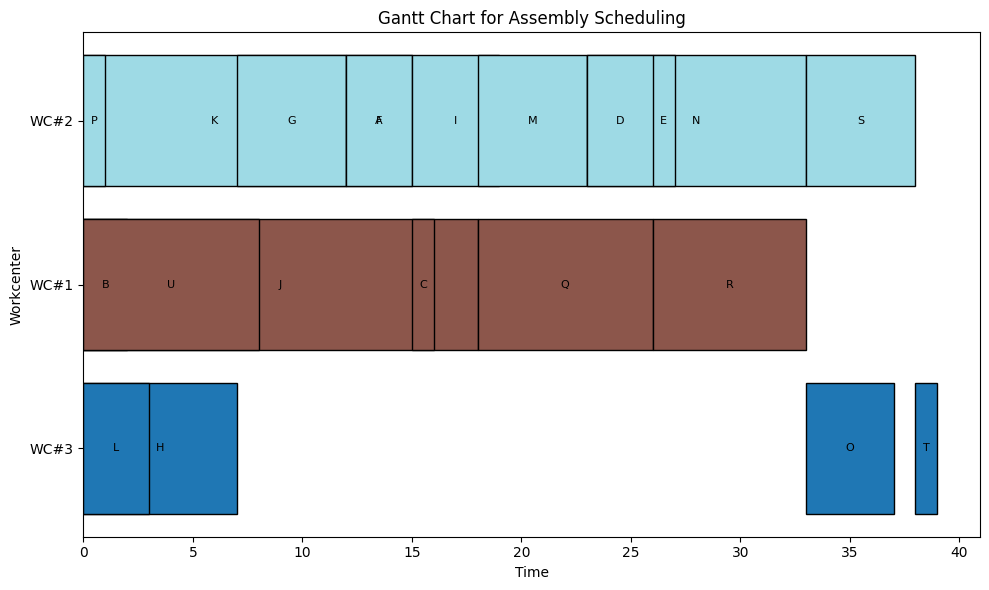

In [26]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [0, 0, 0, 0, 0, 0, 0, 0, 50.0, 0, 0, 0, 0, 0, 80.0, 0, 0, 0, 0, 30.0, 0],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM)
display(df_machine)

operations = load_operations(df_BOM)
workcenters = load_factory(df_machine)

# Assume some initial values for dual costs for demonstration
lambda_ij = {('A', 'C'): 1, ('B', 'D'): 1, ('C', 'E'): 1, ('D', 'E'): 1, ('E', 'F'): 1, ('G', 'F'): 1, ('H', 'G'): 1, ('P', 'R'): 1, ('Q', 'R'): 1, ('R', 'S'): 1, ('U', 'S'): 1}
delta_Y = {wc: 1 for wc in workcenters}

U_ij, V_Y = subgradient_search(workcenters, operations, max_iterations=100, s=0.1)
for wc in workcenters.values():
    solve_spw([op for op in operations.values() if op.workcenter == wc.id], wc, V_Y[wc.id], U_ij)

# print("U_ij:", U_ij)
# print("V_Y:", V_Y)

lower_bound = calculate_lower_bounds(workcenters, operations)
print("Overall Lower Bound:", lower_bound)

# Generate upper bound
upper_bound = generate_upper_bound(operations, workcenters, lower_bound)
print("Upper Bound:", upper_bound)

# Proceed with the rest of the process
schedule_operations(operations, workcenters)
plot_gantt_chart_by_workcenter(operations)

### Test Case #4

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,0.0,3,WC#2,M1
1,B,[],0,0.0,2,WC#1,M2
2,C,[A],0,0.0,1,WC#1,M3
3,D,[B],0,0.0,3,WC#2,M2
4,E,"[C, D]",0,0.0,1,WC#2,M4
5,F,"[E, G]",0,0.0,3,WC#2,M5
6,G,[H],0,0.0,5,WC#2,M1
7,H,[],0,0.0,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,0.0,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


Overall Lower Bound: 18.0
Upper Bound: 37


C:\Users\natha\AppData\Local\Temp\ipykernel_392\1697876345.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(workcenters))


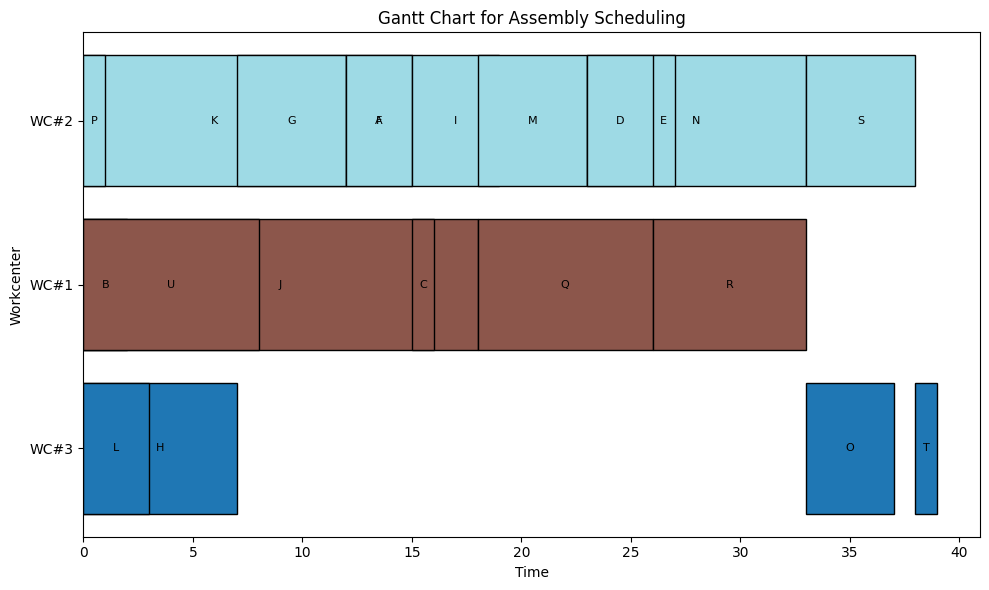

In [27]:
df_BOM = pd.DataFrame({ 
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'], 
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []], 
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], 
    'due_date': [0, 0, 0, 0, 0, 0, 0, 0, 50.0, 0, 0, 0, 0, 0, 80.0, 0, 0, 0, 0, 30.0, 0], 
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8], 
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'], 
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"] 
}) 
df_machine = pd.DataFrame({ 
    'workcenter': ["WC#1", "WC#2", "WC#3"], 
    'M1': [3, 2, 3], 
    'M2': [2, 1, 2], 
    'M3': [1, 2, 1], 
    'M4': [1, 1, 1], 
    'M5': [1, 2, 3] 
}) 
display(df_BOM) 
display(df_machine)

operations = load_operations(df_BOM)
workcenters = load_factory(df_machine)

# Assume some initial values for dual costs for demonstration
# lambda_ij = {('A', 'C'): 1, ('B', 'D'): 1, ('C', 'E'): 1, ('D', 'E'): 1, ('E', 'F'): 1, ('G', 'F'): 1, ('H', 'G'): 1, ('P', 'R'): 1, ('Q', 'R'): 1, ('R', 'S'): 1, ('U', 'S'): 1}
lambda_ij = {('A', 'C'): 1, ('B', 'D'): 1, ('C', 'E'): 1, ('D', 'E'): 1, ('E', 'F'): 1, ('G', 'F'): 1, ('H', 'G'): 1, ('P', 'R'): 1, ('Q', 'R'): 1, ('R', 'S'): 1, ('S', 'T'): 1, ('U', 'T'): 1}
delta_Y = {wc: 1 for wc in workcenters}

U_ij, V_Y = subgradient_search(workcenters, operations, max_iterations=100, s=0.1)
for wc in workcenters.values():
    solve_spw([op for op in operations.values() if op.workcenter == wc.id], wc, V_Y[wc.id], U_ij)

# print("U_ij:", U_ij)
# print("V_Y:", V_Y)

lower_bound = calculate_lower_bounds(workcenters, operations)
print("Overall Lower Bound:", lower_bound)

# Generate upper bound
upper_bound = generate_upper_bound(operations, workcenters, lower_bound)
print("Upper Bound:", upper_bound)

# Proceed with the rest of the process
schedule_operations(operations, workcenters)
plot_gantt_chart_by_workcenter(operations)

# Systematic Testing

In [28]:
import sys 
def print_progress_bar(iteration, total, length=50):
    if iteration == 0:
        return  # Don't print the progress bar when no progress has been made.
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '█' * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r|{bar}| {percent}% Complete')
    sys.stdout.flush()
    if iteration == total:
        print()

In [29]:
# GENERATING THE FACTORY INFORMATION
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
n_workcenters, n_machines = 3, 5
dict_machine = {}
dict_machine[0] = pd.DataFrame({ 'workcenter': [f"WC#{i}" for i in range(1,n_workcenters+1)] })
dict_machine[1] = pd.DataFrame({ 'workcenter': [f"WC#{i}" for i in range(1,n_workcenters+1)] })
dict_machine[2] = pd.DataFrame({ 'workcenter': [f"WC#{i}" for i in range(1,n_workcenters+1)] })

for machine_no in range(1,n_machines+1):
    dict_machine[0][f"M{machine_no}"] = [random.randint(1,5) for _ in range(1,n_workcenters+1)]
    dict_machine[1][f"M{machine_no}"] = [random.randint(1,3) for _ in range(1,n_workcenters+1)]
    dict_machine[2][f"M{machine_no}"] = [random.randint(1,1) for _ in range(1,n_workcenters+1)]

df_results = pd.DataFrame({
    'filename': [None],
    'LETSA_time_0': [None], 'EDD_time_0': [None], 'SA_time_0': [None],
    'LETSA_time_1': [None], 'EDD_time_1': [None], 'SA_time_1': [None],
    'LETSA_time_2': [None], 'EDD_time_2': [None], 'SA_time_2': [None],
    'LETSA_makespan_0': [None], 'EDD_makespan_0': [None], 'SA_makespan_0': [None],    
    'LETSA_makespan_1': [None], 'EDD_makespan_1': [None], 'SA_makespan_1': [None],
    'LETSA_makespan_2': [None], 'EDD_makespan_2': [None], 'SA_makespan_2': [None]    
})

paths = os.listdir('TestCases') 
folders =  [item for item in paths if item[-3:] != "csv"]
folders.sort(reverse=True)
for folder in folders: 
    print(f"Running code for {folder}")
    files = os.listdir(f"TestCases//{folder}")
    if not os.path.exists(f"TestResults//{folder}"):
        os.makedirs(f"TestResults//{folder}")
    # ===============
    #       SA
    # ===============
    # print("Testing cases for SA")
    # for i, filename in enumerate(files): 
    #     df_BOM = pd.read_csv(f"TestCases//{folder}//{filename}")
    #     df_BOM['predecessor_operations'] = df_BOM['predecessor_operations'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
    #     df_results.at[i, "filename"] = filename

    #     for j in range(3): 
    #         df_machine = dict_machine[j]

    #         start = time.time()
    #         df_scheduled, best_makespan = SA_main(df_BOM, df_machine)
    #         end = time.time()

    #         df_results.at[i, f"SA_makespan_{j}"] = best_makespan
    #         df_results.at[i, f"SA_time_{j}"] = end - start 
    #         df_scheduled.to_csv(f"TestResults//{folder}//{filename[:-4]}_SA_{j}.csv")
    #         print_progress_bar((i*3)+(j+1), (3*len(files)))

    #     if i % 10 == 0: 
    #         df_results.to_csv("TestResults//TestResults.csv")


Running code for 50operations
Running code for 30operations
Running code for 200operations
Running code for 15operations
Running code for 100operations


In [30]:
operations = load_operations(df_BOM)
workcenters = load_factory(df_machine)

lambda_ij = {}
for idx, row in df_BOM.iterrows():
    list_predeceessors = row['predecessor_operations']
    successor = row['operation']
    for predecessor in list_predeceessors:
        lambda_ij[(predecessor, successor)] = 1

print(lambda_ij)

{('A', 'C'): 1, ('B', 'D'): 1, ('C', 'E'): 1, ('D', 'E'): 1, ('E', 'F'): 1, ('G', 'F'): 1, ('H', 'G'): 1, ('F', 'I'): 1, ('J', 'M'): 1, ('K', 'M'): 1, ('L', 'M'): 1, ('M', 'N'): 1, ('N', 'O'): 1, ('P', 'R'): 1, ('Q', 'R'): 1, ('R', 'S'): 1, ('S', 'T'): 1, ('U', 'T'): 1}


In [ ]:
def LR_schedule_operations(operations, factory):
    U_ij, V_Y = subgradient_search(factory, operations, max_iterations=100, s=0.1)
    for wc in factory.values():
    solve_spw([op for op in operations.values() if op.workcenter == wc.id], wc, V_Y[wc.id], U_ij)
    lower_bound = calculate_lower_bounds(factory, operations)

